# Predicting Heart Disease with a Classification Model

# Introduction: 

Heart disease can lead to fatal heart attacks, so must be treated seriously. In this project, we will analyze past data of patients to try to predict heart disease in a person, with the person’s given medical records.

Our data set comes from the “Heart Disease Data Set” from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. This data set has attributes of patient's medical history and whether or not they have heart disease. We will be using the `processed.cleveland.data` data set to answer the question:

*Is it possible to use existing patient chart data with different attributes of the patient to predict the likelihood of a new patient having heart disease with the help of a classification model?*



# Preliminary exploratory data analysis: 

In [1]:
### Run the R libraries 
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10) #This can only show 10 rows of the dataframe.



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names= FALSE)
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "disease_type")
cleveland_data <- mutate(cleveland_data, disease_type = as_factor(disease_type))
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3


### Cleaning the data by using filter() functions:
Our first step is to filter out the missing rows in the *thal* column and "?" in the *ca* column.

In [3]:
filter_cleveland_data <- cleveland_data |>
    filter(thal != "?", ca != "?") |>
    drop_na()


In order to make a valid prediction, we will only look at whether or not patients have heart disease. *disease_type* has 4 values representing the presence of heart disease, so we mutate this column into "No = no heart disease" and "Yes = has heart disease"

In [4]:
new_cleveland_data <- filter_cleveland_data |> mutate(have_heart_disease = ifelse(disease_type == 0, "No", "Yes"))|>
mutate(ca = as.numeric(ca), thal = as.numeric(thal)) #turn "ca" and "thal" to numeric vectors.
new_cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_type,have_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,No
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,Yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,No
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,140,241,0,0,123,1,0.2,2,0,7,1,Yes
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1,Yes
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2,Yes


Now we split 75% of the data into a training set, and the rest a testing set.

In [5]:
# Set the seed.
set.seed(3456) 

# Split the data into 75% and 25%.
data_split <- initial_split(new_cleveland_data, prop = 0.75, strata = have_heart_disease)  

heart_train_set <- training(data_split)   
heart_test_set <- testing(data_split)

We plot the presence of heart disease in our data to know how much our prediction comes from the predictors instead of randomness.

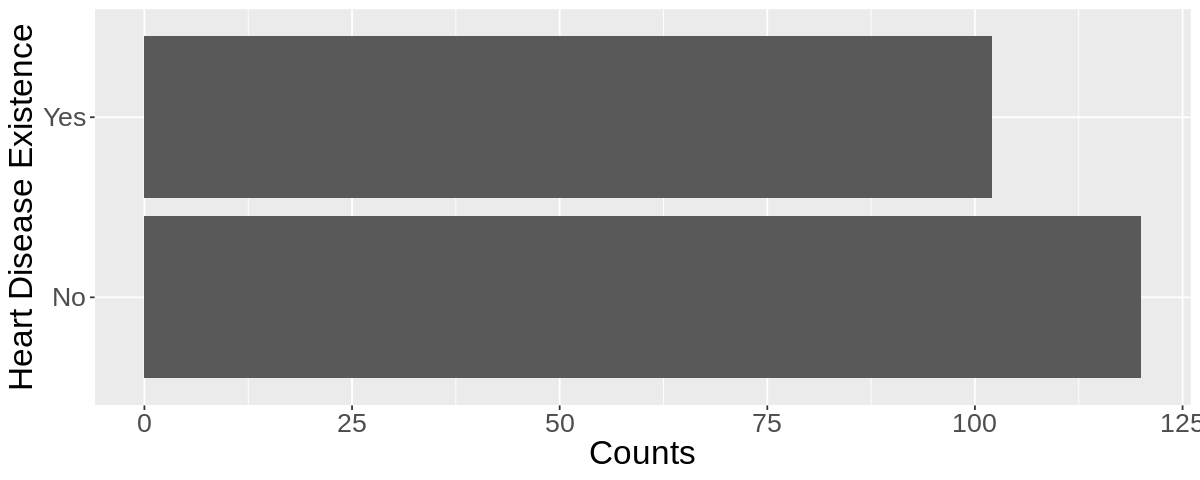

In [6]:
options(repr.plot.width = 10, repr.plot.height = 4)

counting_types <- heart_train_set |>
    group_by(have_heart_disease)|>
    summarize(types_count = n()) 

exsitance_plot<- counting_types |>
ggplot(aes( x = have_heart_disease,
            y = types_count)) +
    geom_bar(position='stack', stat='identity') +
    scale_fill_manual(values=c('red', 'purple'))+
    coord_flip() +
    labs(x = "Heart Disease Existence", y = "Counts") +
    theme(text = element_text(size = 20))
exsitance_plot


# Methods: 

Of the variables in the data, some influence heart disease more than others. We researched this topic and decided on the following predictors:
- age
- sex:
    - 0 = male
    - 1 = female
- thalach: maximum heart rate achieved (bpm)
- exang: exercise-induced angina (1 = yes; 0 = no)
- oldpeak: ST depression
- slope: the slope of the peak exercise ST segment
- ca: number of major vessels (0-3) colored by flourosopy
- thal: thalassemia
    - 3 = normal
    - 6 = fixed defect
    - 7 = reversable defect


Now we will make a few plots to explore how our predictors affect the target variable. These can be used to form hypotheses and check if the results match with what was predicted.

`geom_smooth()` using formula 'y ~ x'



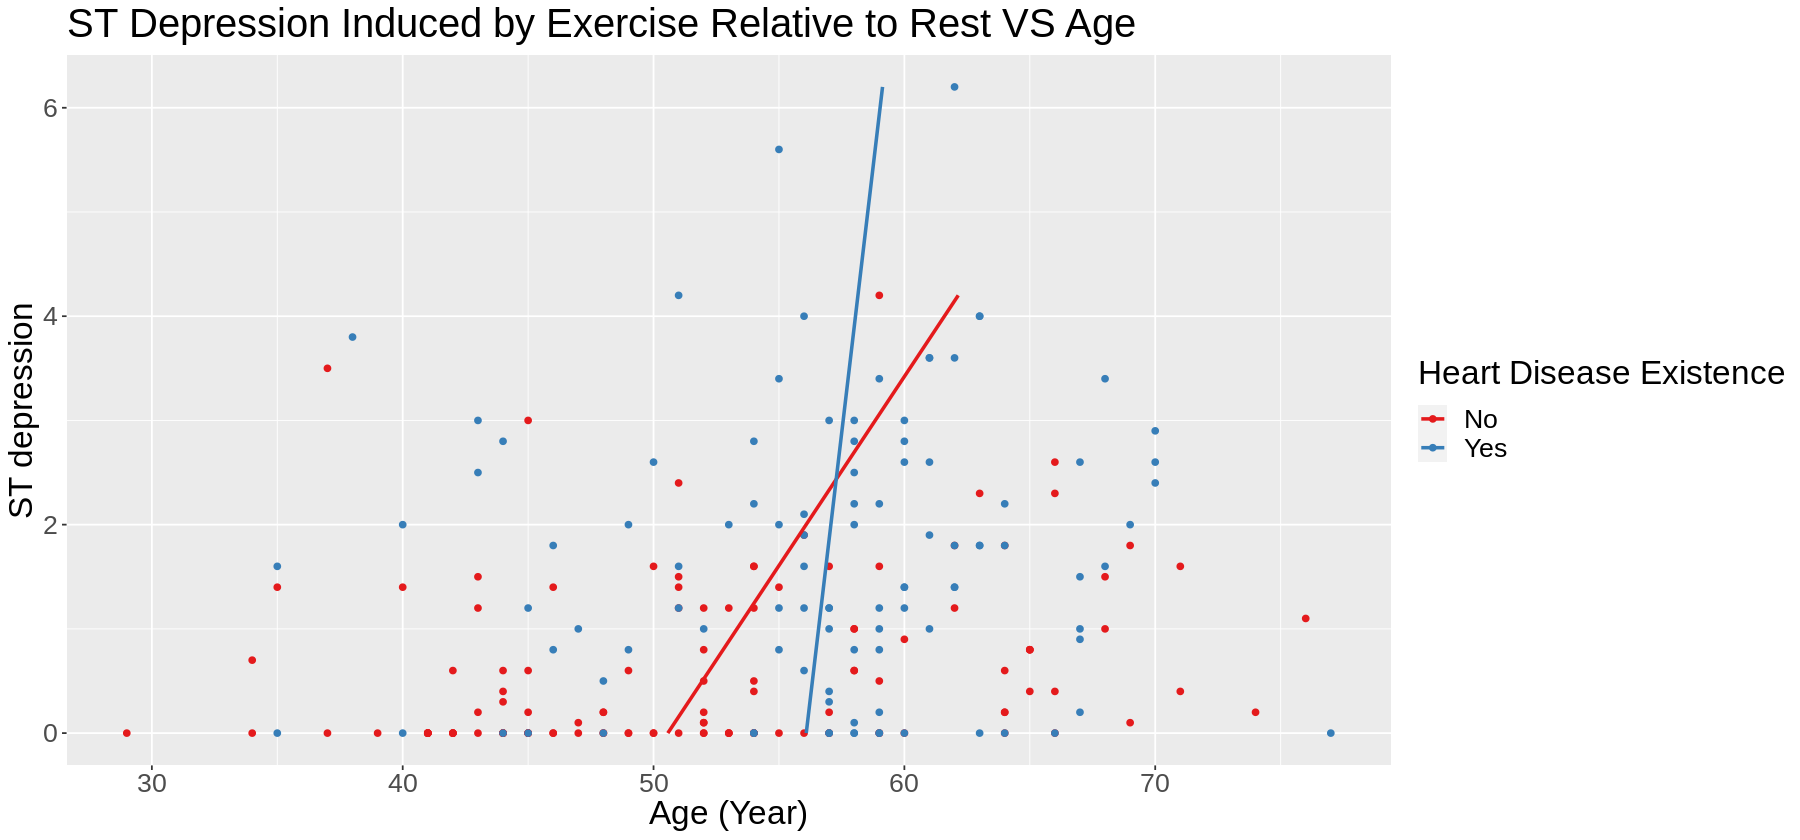

In [7]:
options(repr.plot.width = 15, repr.plot.height = 7)

oldpeak_vs_age<- heart_train_set |>
ggplot(aes( x = oldpeak,
            y = age, color= have_heart_disease)) +
    geom_point(stat = 'identity') +
    coord_flip() +
    labs(x = "ST depression", y = "Age (Year)", color = "Heart Disease Existence") +
    theme(text = element_text(size = 20)) +
    geom_smooth(method=lm,se=FALSE)+
    scale_color_brewer(palette="Set1")+
    ggtitle("ST Depression Induced by Exercise Relative to Rest VS Age")
oldpeak_vs_age

In this first plot above, there is a tendency of higher heart disease presence with higher age and higher ST depression.

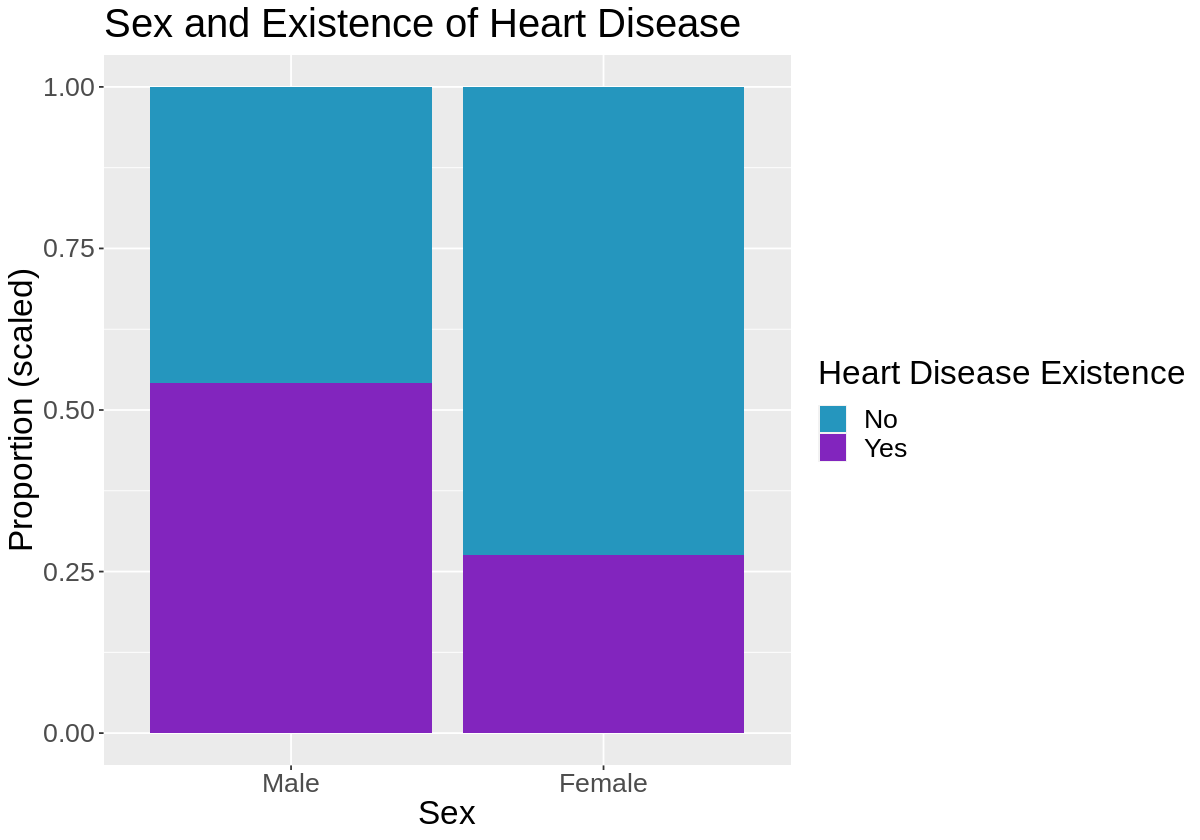

In [8]:
options(repr.plot.width = 10, repr.plot.height = 7)



sex_plot<- heart_train_set |>
    mutate(sex = ifelse(sex == 0, "Female", "Male")) |>
    mutate(sex = as_factor(sex)) |>
    ggplot(aes(x = sex, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Sex", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Sex and Existence of Heart Disease")
sex_plot

Heart disease is more apparent in males.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



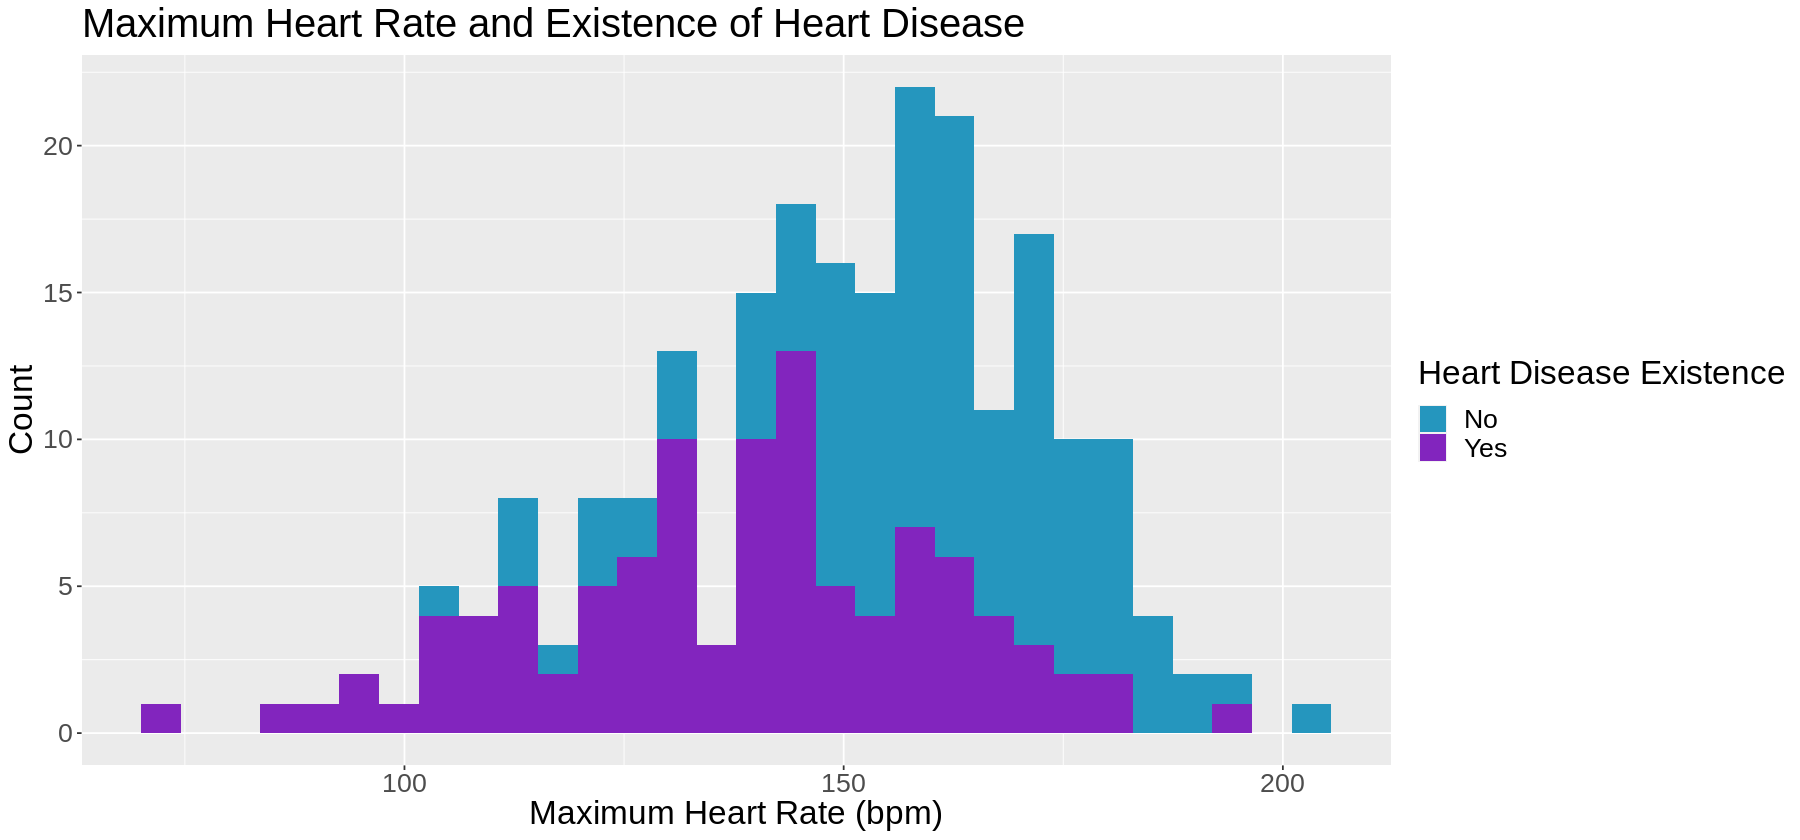

In [9]:
options(repr.plot.width = 15, repr.plot.height = 7)

thalach_plot<- heart_train_set |>
ggplot(aes(x = thalach,fill = have_heart_disease)) +
    geom_histogram() +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Maximum Heart Rate (bpm)", y = "Count", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Maximum Heart Rate and Existence of Heart Disease")
thalach_plot

Heart rates on the lower end are more associated with having heart disease.

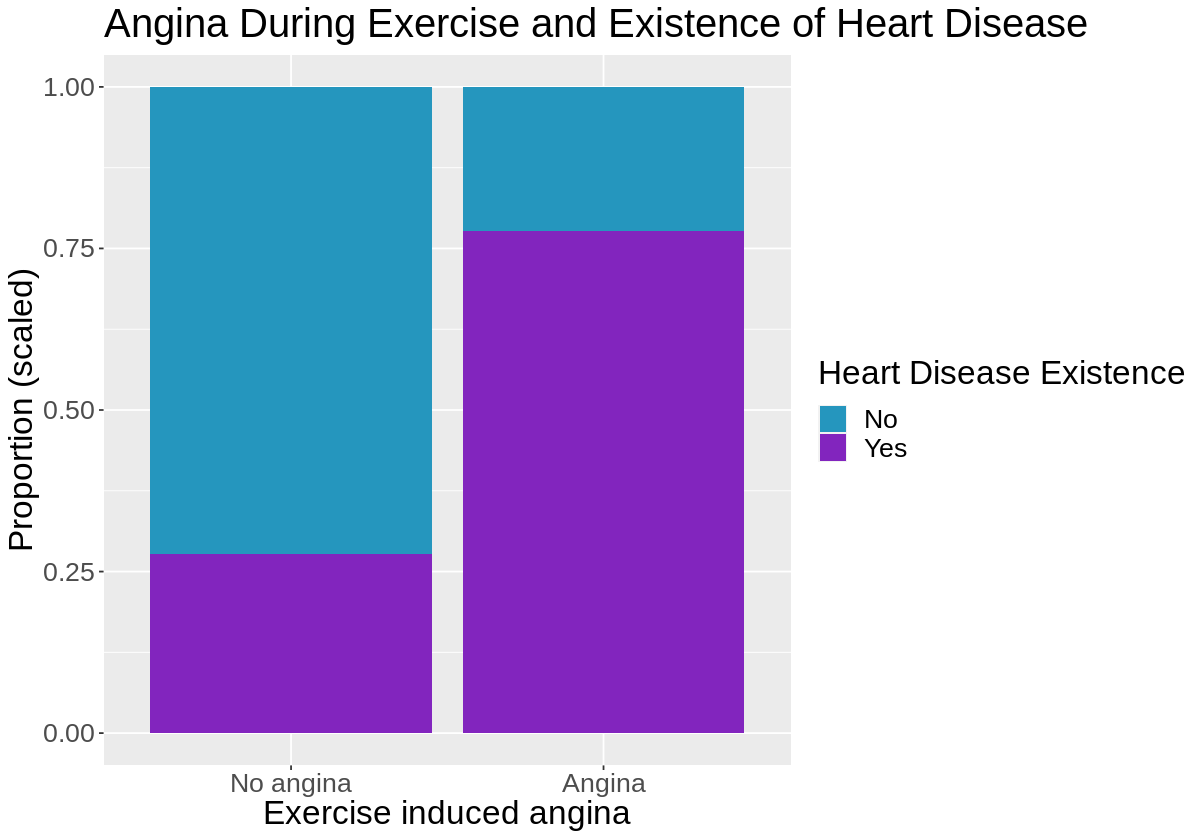

In [17]:
options(repr.plot.width = 10, repr.plot.height = 7)

exang_plot<- heart_train_set |>
    mutate(exang = ifelse(exang == 0, "No angina", "Angina")) |>
    mutate(exang = as_factor(exang)) |>
    ggplot(aes(x = exang, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Exercise induced angina", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Angina During Exercise and Existence of Heart Disease")
exang_plot

There is a higher proportion of heart disease of patients with exercise-induced angina.

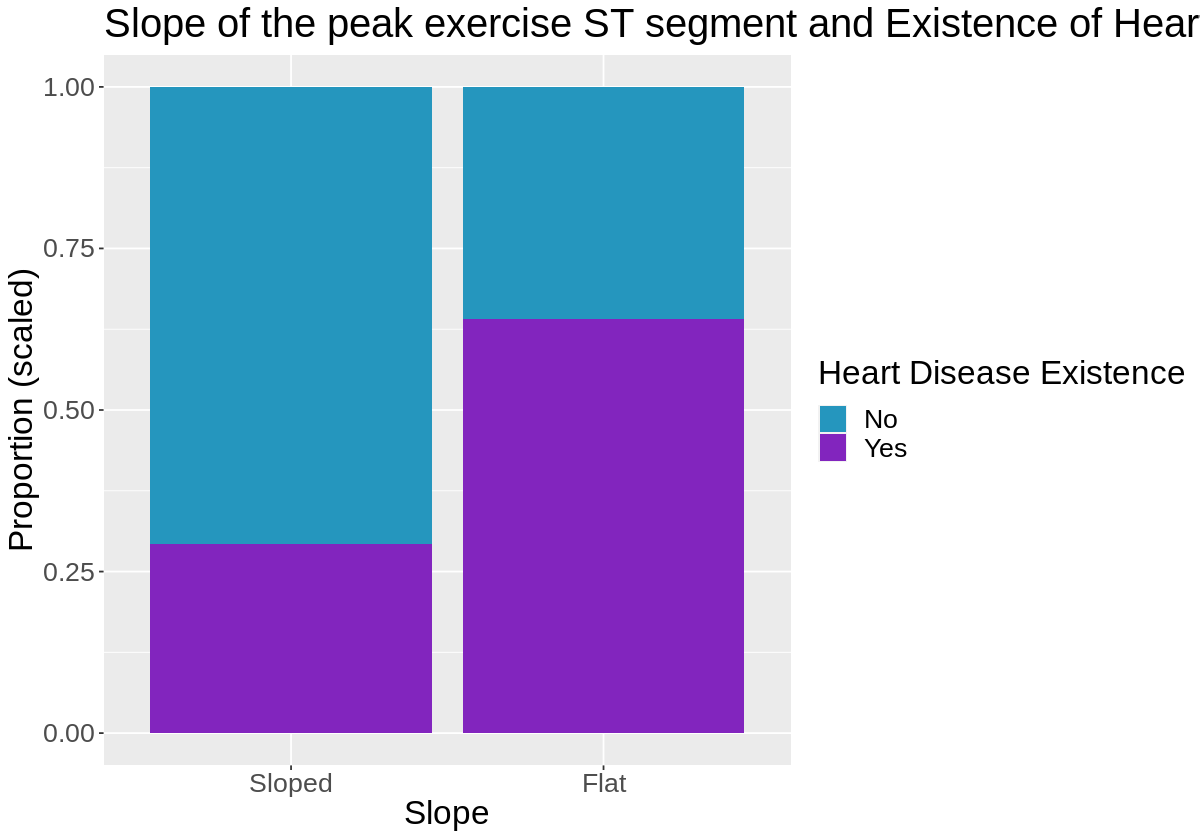

In [18]:
options(repr.plot.width = 10, repr.plot.height = 7)

slope_plot<- heart_train_set |>
     mutate(slope = ifelse(slope == 2, "Flat", "Sloped")) |>
    mutate(slope = as_factor(slope)) |>
    ggplot(aes(x = slope, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Slope", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Slope of the peak exercise ST segment and Existence of Heart Disease")
slope_plot

Having a flat slope of the peak exercise ST segment of an electrocardiogram has a higher proportion of heart disease.

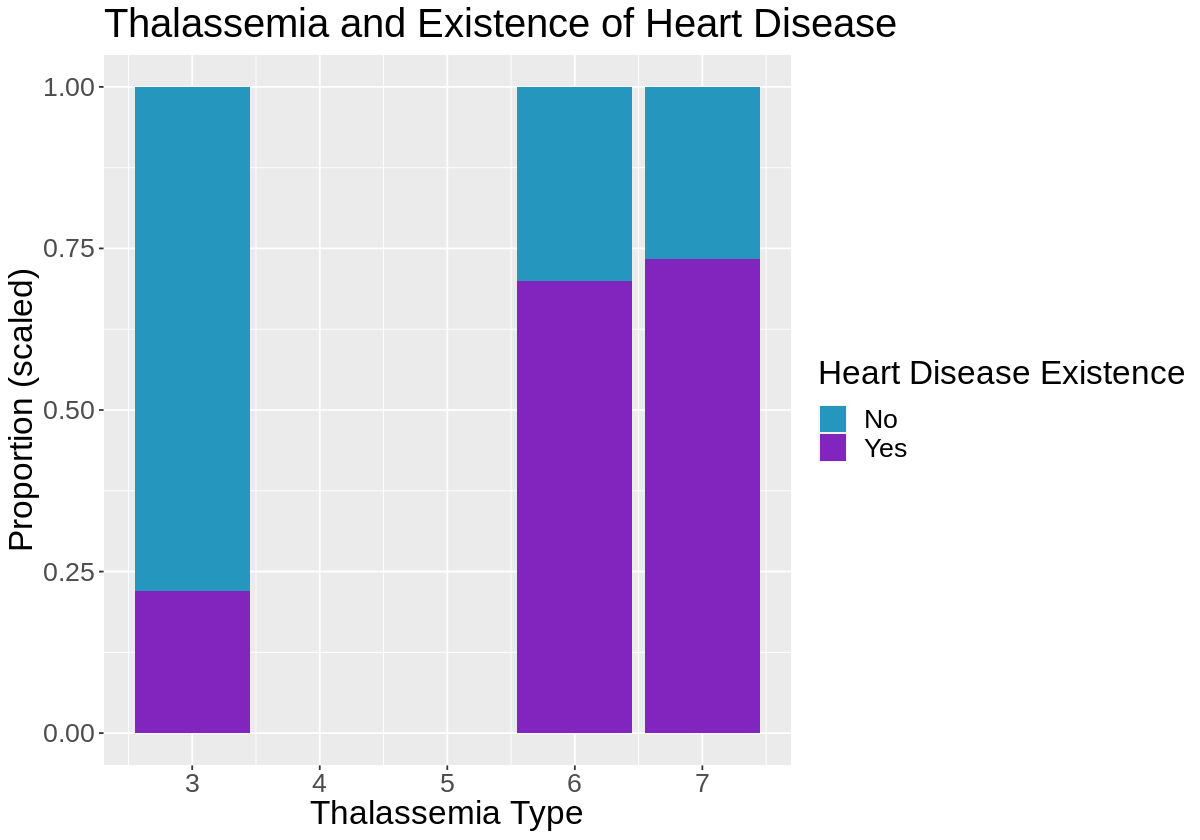

In [19]:
options(repr.plot.width = 10, repr.plot.height = 7)

thal_plot<- heart_train_set |>
    ggplot(aes(x = thal, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Thalassemia Type", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Thalassemia and Existence of Heart Disease")
thal_plot

A reversible defect of thalassemia has the highest relative presence of heart disease.

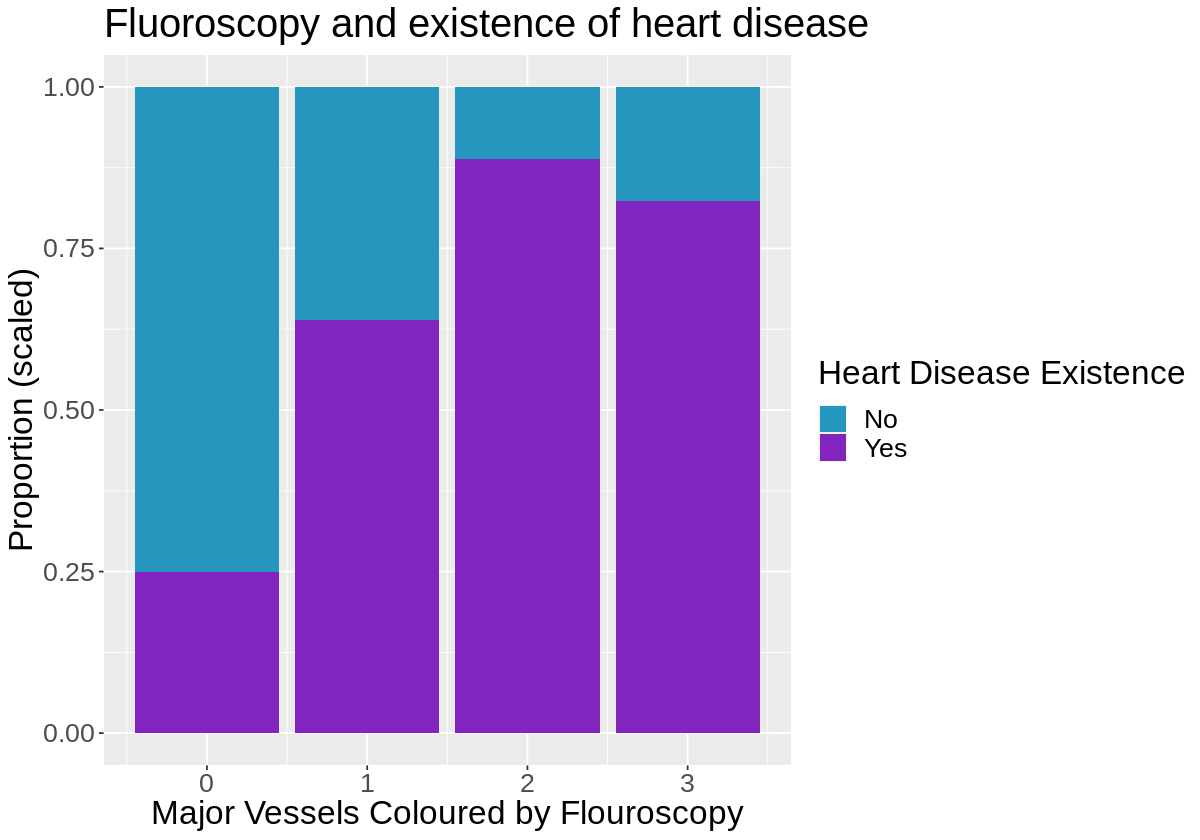

In [20]:
options(repr.plot.width = 10, repr.plot.height = 7)

ca_plot<- heart_train_set |>
    ggplot(aes(x = ca, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Major Vessels Coloured by Flouroscopy", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Fluoroscopy and existence of heart disease")
ca_plot

More major vessels coloured by fluoroscopy leads to higher proportions of heart disease.

# Expected outcomes and significance:

## What do you expect to find?
We expect that the predictions should match what we hypothesized from the plots above, and that we predict with a high accuracy.

## What impact could such findings have? 
As heart disease can take lives, these findings could help us identify the disease and prevent it before it becomes too dangerous and also save medical costs.



## What future questions could this lead to?
How well does the classification model behave with other populations (not just Cleveland)?

How can insights from our model can be used to develop heart disease prevention strategies?

What attributes were the strongest predictor of heart disease?


# Building the classification model：

In order to reach the higest auccuracy, we will perform forward selection on our data:

In [14]:
new_cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_type,have_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,No
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,Yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,No
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,140,241,0,0,123,1,0.2,2,0,7,1,Yes
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1,Yes
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2,Yes


In [15]:
set.seed(233)

names <- colnames(new_cleveland_data |> select(-disease_type))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(new_cleveland_data, v = 5, strata = disease_type)

In [16]:
set.seed(233)
#for every size from 1 to the total number of predictors

for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("disease_type", "~", paste(preds_new, collapse="+"))

        heart_recipe <- recipe(as.formula(model_string), data = new_cleveland_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

     
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

      
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    heart_acc <- heart_acc |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

print(accuracies)

ERROR: Error in eval(expr, envir, enclos): object 'n_total' not found


## References

1. Centers for Disease Control and Prevention. (2022, September 8). Heart disease and stroke. Centers for Disease Control and Prevention. Retrieved March 15, 2023, from https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity. 
2. Centers for Disease Control and Prevention. (2023, March 21). About heart disease. Centers for Disease Control and Prevention. Retrieved March 15, 2023, from https://www.cdc.gov/heartdisease/about.htm#:~:text=What%20is%20heart%20disease%3F,can%20cause%20a%20heart%20attack. 
3. Singh, P., Singh, S., &amp; Pandi-Jain, G. S. (2018, March 15). Effective heart disease prediction system using data mining techniques. International journal of nanomedicine. Retrieved March 15, 2023, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5863635/#:~:text=The%20diagnosis%20of%20heart%20disease%20is%20usually%20based%20on%20signs,and%20lack%20of%20physical%20exercise. 